# Manipulate 2021 LSOA boundary data from EW to London

Aim is to produce a .csv containing geometries that can later be joined to other data for analysis. This file will be used by students regularly so should be a relatively small file on disk.    

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-08-23


In [2]:
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt

Data downloaded from: https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2021-boundaries-full-clipped-ew-bfc/about

In [3]:
boundaries = gpd.read_file("data/inputs/geographies/Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_Full_Clipped_EW_(BFC)/LSOA_2021_EW_BFC_V7.shp").set_index('LSOA21NM')

In [4]:
boundaries.head()

,OBJECTID,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
LSOA21NM,,,,,
City of London 001A,1,E01000001,2635.767993,129865.314435,"POLYGON ((532151.537 181867.433, 532152.500 18..."
City of London 001B,2,E01000002,2707.816821,228419.782304,"POLYGON ((532634.497 181926.016, 532632.048 18..."
City of London 001C,3,E01000003,1224.573160,59054.204611,"POLYGON ((532153.703 182165.155, 532158.250 18..."
City of London 001E,4,E01000005,2275.805344,189577.709493,"POLYGON ((533619.062 181402.364, 533639.868 18..."
Barking and Dagenham 016A,5,E01000006,1966.092607,146536.995720,"POLYGON ((545126.852 184310.838, 545145.213 18..."


Looks like London LSOAs are listed at the top, so slice down to bottom LSOA (Westminster 013D)

In [5]:
london = boundaries.loc[:'Westminster 013D',:]
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4506 entries, City of London 001A to Westminster 013D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4506 non-null   int64   
 1   LSOA21CD    4506 non-null   object  
 2   SHAPE_Leng  4506 non-null   float64 
 3   SHAPE_Area  4506 non-null   float64 
 4   geometry    4506 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 211.2+ KB


<AxesSubplot:>

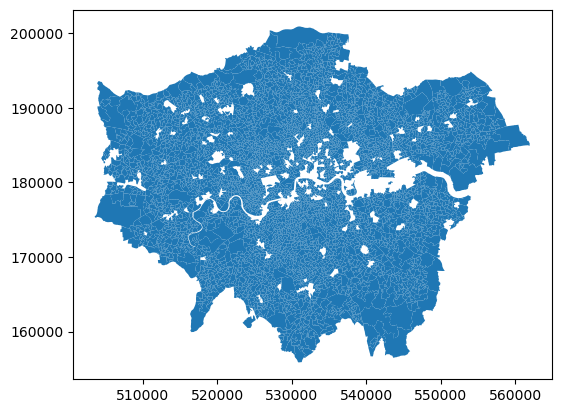

In [6]:
london.plot()

Unfortunately, we have missing polygons. So, we should select LSOAs based on boroughs (plus City). 

Get borough names from LSOA (2011) to LSOA (2021) to Local Authority District (2022) Lookup data [NB: 2022-08-19 this was removed, to be replaced](https://twitter.com/ONSgeography/status/1560576734600302592)

In [7]:
sam = pd.read_csv("data/inputs/geographies/LSOA11_LSOA21_LAD22_EW_LU.csv")
sam.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN


London boroughs _are_ listed first, so we can get list of borough names relatively easily:

In [8]:
lads = list(pd.unique(sam.LAD22NM))
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [9]:
len(london_lads)

33

We want to use the LSOA names as a Series below, so extract them from index (and set dytype to string)

In [10]:
boundaries = boundaries.reset_index()
boundaries['LSOA21NM'] = boundaries['LSOA21NM'].astype('string')
boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA21NM    35672 non-null  string  
 1   OBJECTID    35672 non-null  int64   
 2   LSOA21CD    35672 non-null  object  
 3   SHAPE_Leng  35672 non-null  float64 
 4   SHAPE_Area  35672 non-null  float64 
 5   geometry    35672 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(1), string(1)
memory usage: 1.6+ MB


Now filter to retain only rows for _LSOA21NM_ contains some text in the _london_lads_ list (do shallow copy to avoid index issue later)

In [11]:
london = boundaries[boundaries['LSOA21NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5042 entries, 0 to 33715
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA21NM    5042 non-null   string  
 1   OBJECTID    5042 non-null   int64   
 2   LSOA21CD    5042 non-null   object  
 3   SHAPE_Leng  5042 non-null   float64 
 4   SHAPE_Area  5042 non-null   float64 
 5   geometry    5042 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1), string(1)
memory usage: 275.7+ KB


Plot to check

<AxesSubplot:>

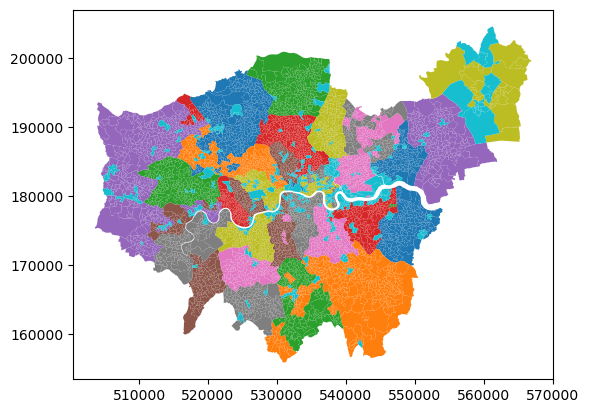

In [12]:
london.plot('LSOA21CD')

What's going on here? We have some unexpected LSOAs in north east. Let's do some more plotting to investigate

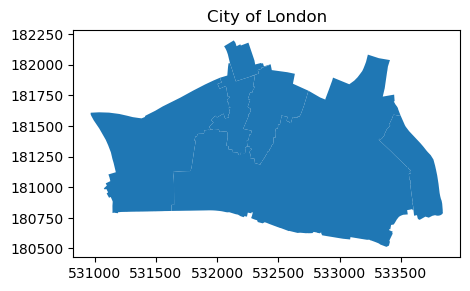

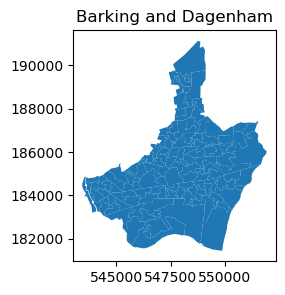

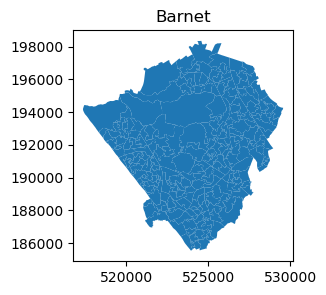

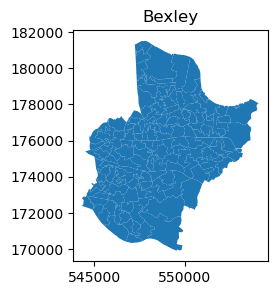

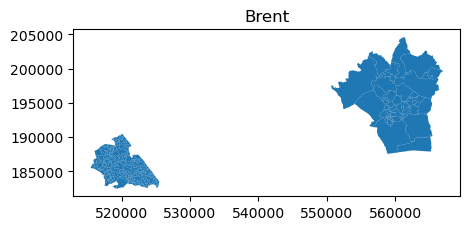

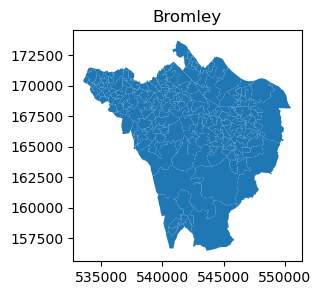

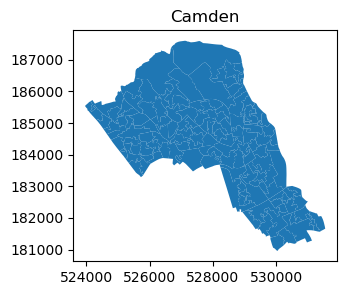

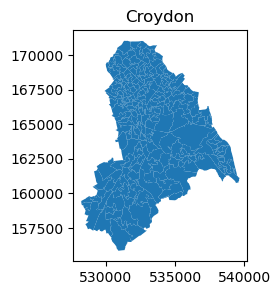

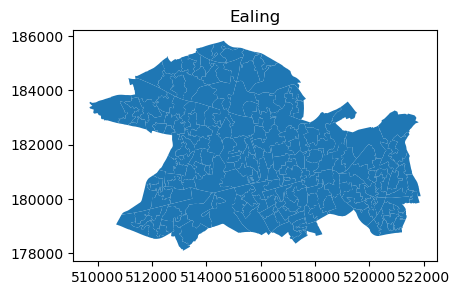

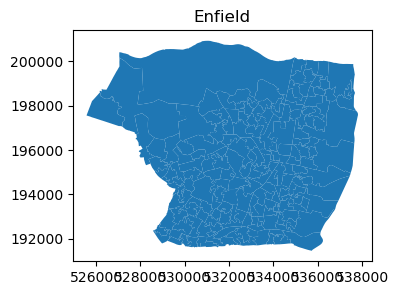

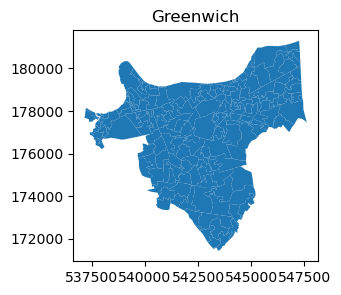

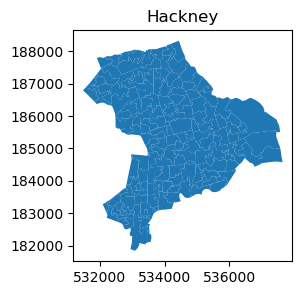

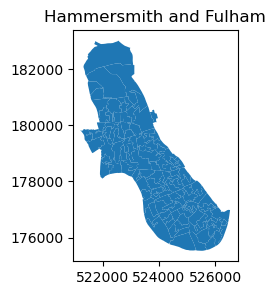

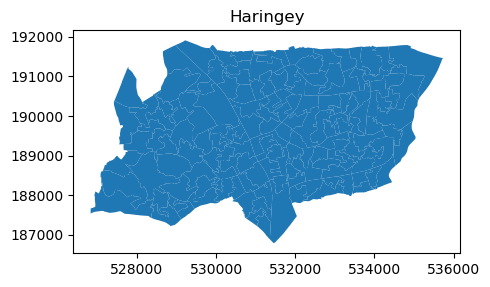

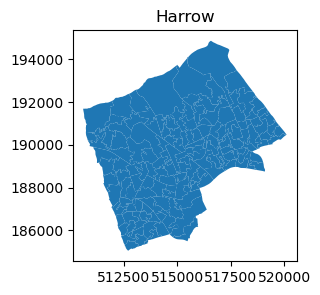

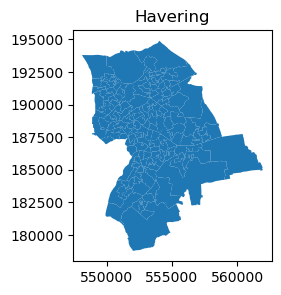

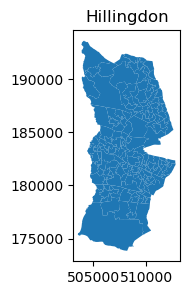

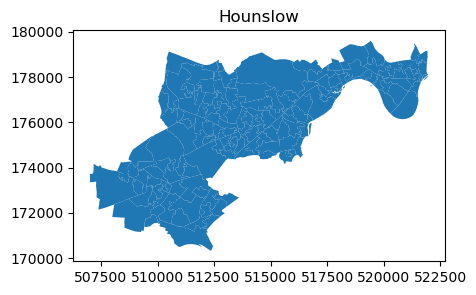

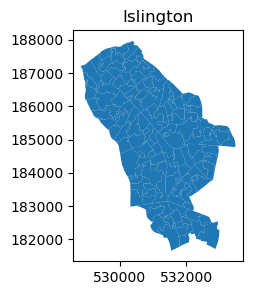

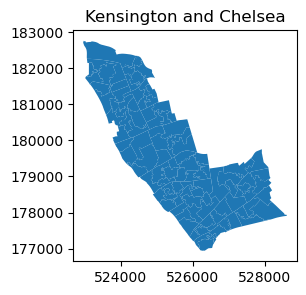

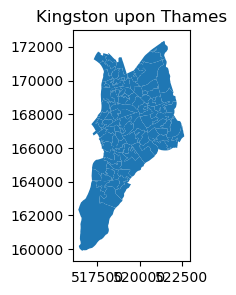

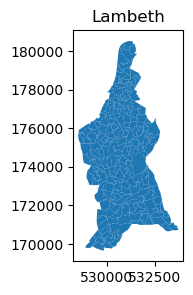

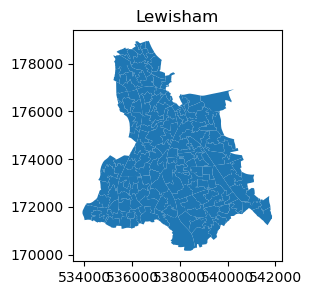

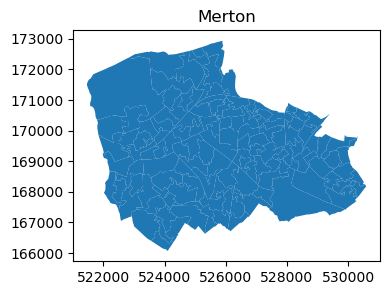

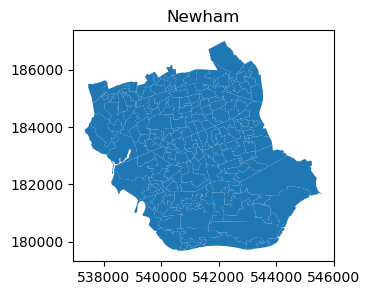

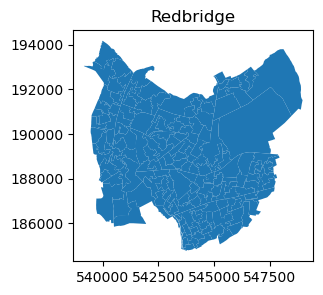

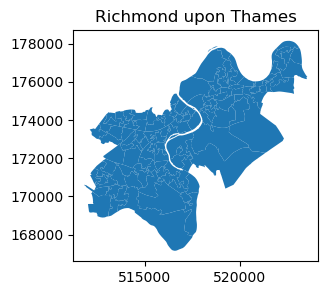

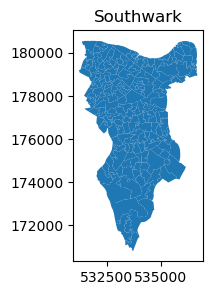

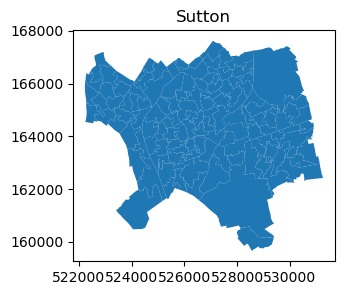

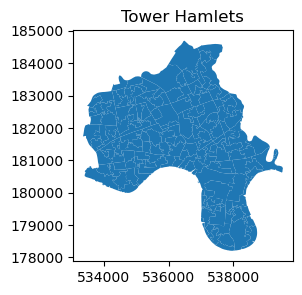

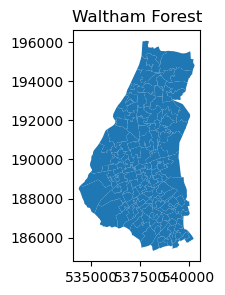

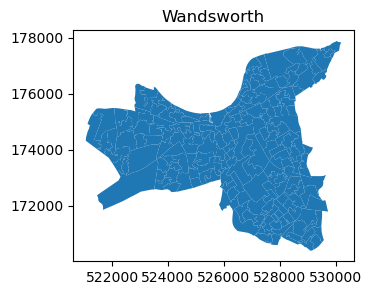

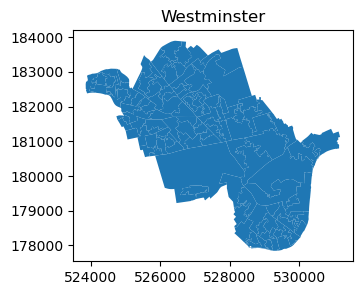

In [13]:
for x in london_lads:
    l = london[london['LSOA21NM'].str.contains(x)]
    #print(x)
    #l.plot()
    fig, ax = plt.subplots(1, figsize=(5, 3))
    ax = l.plot(ax=ax)
    ax.set_title(x)
    plt.show()

It looks like Brent is the problem

<AxesSubplot:>

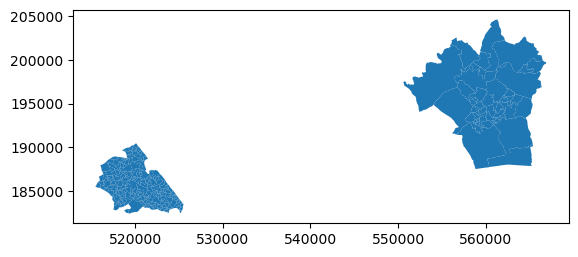

In [14]:
london[london['LSOA21NM'].str.contains('Brent')].plot()

In [15]:
london[london['LSOA21NM'].str.contains('Brent')]

,LSOA21NM,OBJECTID,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
454,Brent 026A,455,E01000471,1858.770681,139033.027206,"POLYGON ((518816.208 183497.387, 518817.814 18..."
455,Brent 029A,456,E01000472,3503.473350,432847.246455,"POLYGON ((518119.033 183705.224, 518098.000 18..."
456,Brent 029B,457,E01000473,3775.527656,173634.719432,"POLYGON ((518402.056 184434.910, 518389.653 18..."
457,Brent 026B,458,E01000474,3091.453160,196455.352914,"POLYGON ((518453.219 184653.437, 518455.625 18..."
458,Brent 029C,459,E01000475,4062.550728,312195.150359,"POLYGON ((518033.000 183755.000, 518000.000 18..."
...,...,...,...,...,...,...
31983,Brent 035D,31984,E01033942,3305.458563,284149.257375,"POLYGON ((519162.251 185932.450, 519162.777 18..."
32396,Brentwood 007H,32397,E01034358,2955.344792,283821.841354,"POLYGON ((560074.530 193996.531, 560074.562 19..."
32397,Brentwood 007I,32398,E01034359,3453.652901,368228.654680,"POLYGON ((558727.608 193992.528, 558760.923 19..."
32398,Brentwood 007J,32399,E01034360,2980.162461,415990.817409,"POLYGON ((559710.643 193632.117, 559711.713 19..."


Last few rows show that Brentwood is being included as well as Brent!  So filter Brentwood out

In [16]:
london_noBrentwood = london[~london['LSOA21NM'].str.contains('Brentwood')]

<AxesSubplot:>

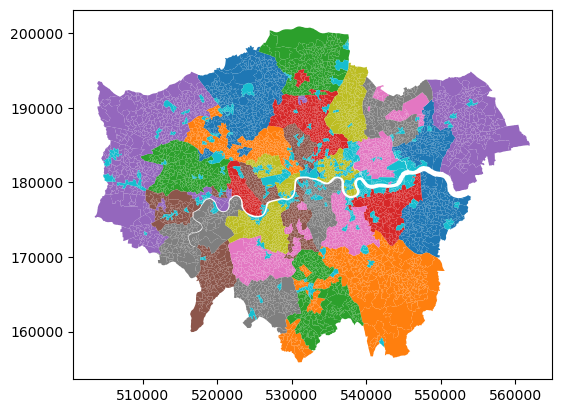

In [17]:
london_noBrentwood .plot('LSOA21CD')

This looks like what we want. Now output data

In [19]:
london_noBrentwood.to_file("data/geographies/london2021-lsoa.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [20]:
#london_noBrentwood.to_csv("data/geographies/london2021-lsoa.csv")

Data files written to file are quite large (~40MB for .shp and ~85MB for .csv). Use GeoPandas.simplify to reduce file size.

First check CRS of the file to understand units for tolerance parameter. 

In [21]:
london_noBrentwood.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [22]:
london_noB_simple = london_noBrentwood.copy(deep=False)
london_noB_simple.geometry = london_noBrentwood.simplify(tolerance=10)
london_noB_simple.head()

,LSOA21NM,OBJECTID,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
0,City of London 001A,1,E01000001,2635.767993,129865.314435,"POLYGON ((532151.537 181867.433, 532308.875 18..."
1,City of London 001B,2,E01000002,2707.816821,228419.782304,"POLYGON ((532634.497 181926.016, 532618.688 18..."
2,City of London 001C,3,E01000003,1224.573160,59054.204611,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,City of London 001E,4,E01000005,2275.805344,189577.709493,"POLYGON ((533619.062 181402.364, 533765.806 18..."
4,Barking and Dagenham 016A,5,E01000006,1966.092607,146536.995720,"POLYGON ((545126.852 184310.838, 545296.239 18..."


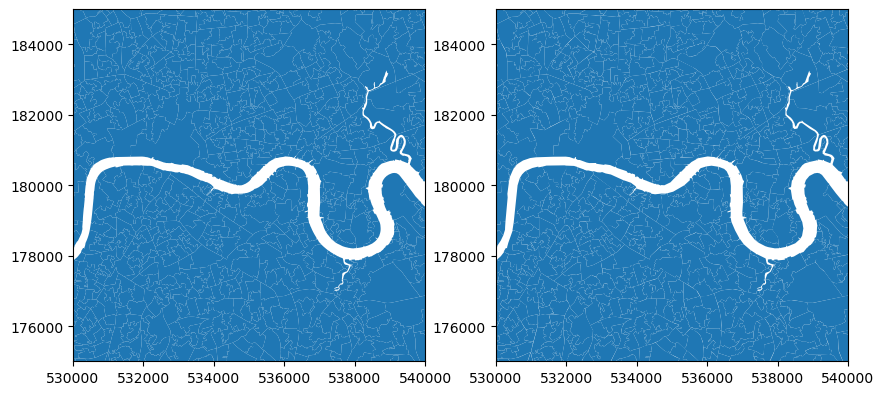

In [23]:
custom_xlim=(530000,540000)
custom_ylim=(175000,185000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
london_noBrentwood.plot(ax=ax[0])
london_noB_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

Simplifying with `tolerance=10` seems to have limitied impact on visualisation at intermediate scales.

We can see some impact at fine scales

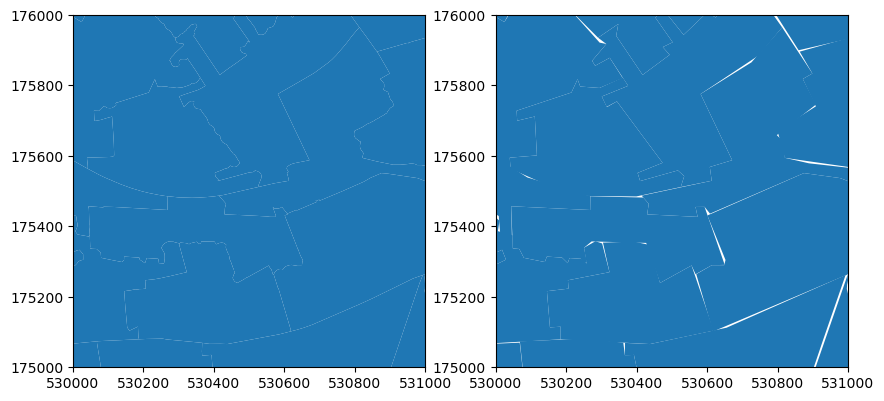

In [24]:
custom_xlim=(530000,531000)
custom_ylim=(175000,176000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
london_noBrentwood.plot(ax=ax[0])
london_noB_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

But at Borough level, visualisation is fine. We'll use this tolerance (if students want to use the original we can make that available as .shp).

<AxesSubplot:>

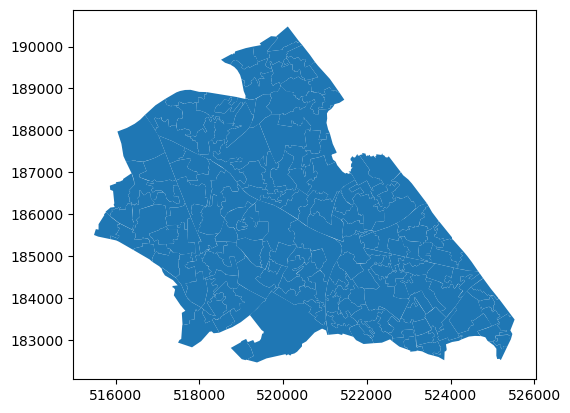

In [25]:
london_noB_simple[london_noB_simple['LSOA21NM'].str.contains('Brent')].plot()

In [26]:
#write to file
london_noB_simple.to_csv("data/geographies/london2021-lsoa_simple.csv")

Given units for EPSG:27000 (BNG) are metres we don't need multiple decimal places. We can remove as follows

In [27]:
# first step from https://gis.stackexchange.com/a/336382
london_noB_trunc = london_noB_simple.copy(deep=False)
london_noB_trunc.geometry = london_noB_simple.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,rounding_precision=0)))
london_noB_trunc.geometry = london_noB_trunc.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,trim=True)))

This also seems to have limited impact on visualisation (but will further reduce csv file size):

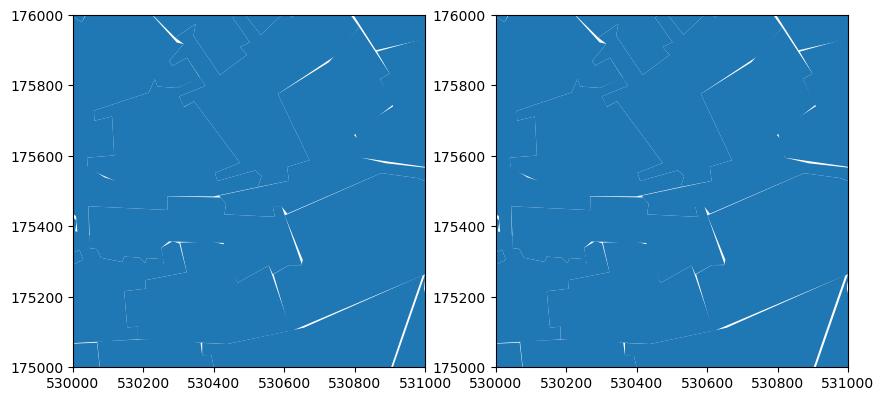

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
london_noB_simple.plot(ax=ax[0])
london_noB_trunc.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

<AxesSubplot:>

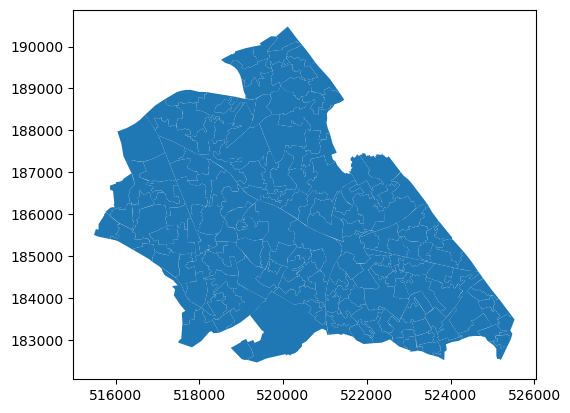

In [29]:
london_noB_trunc[london_noB_trunc['LSOA21NM'].str.contains('Brent')].plot()

So now we can write to file:

In [30]:
london_noB_trunc.to_csv("data/geographies/london2021-lsoa_trunc.csv")

Read back in to check:

In [31]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = "data/geographies/london2021-lsoa_trunc.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [32]:
gdf.head()

,Unnamed: 0,LSOA21NM,OBJECTID,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
0,0,City of London 001A,1,E01000001,2635.767993,129865.314435,"POLYGON ((532152.000 181867.000, 532309.000 18..."
1,1,City of London 001B,2,E01000002,2707.816821,228419.782304,"POLYGON ((532634.000 181926.000, 532619.000 18..."
2,2,City of London 001C,3,E01000003,1224.573160,59054.204611,"POLYGON ((532154.000 182165.000, 532158.000 18..."
3,3,City of London 001E,4,E01000005,2275.805344,189577.709493,"POLYGON ((533619.000 181402.000, 533766.000 18..."
4,4,Barking and Dagenham 016A,5,E01000006,1966.092607,146536.995720,"POLYGON ((545127.000 184311.000, 545296.000 18..."


<AxesSubplot:>

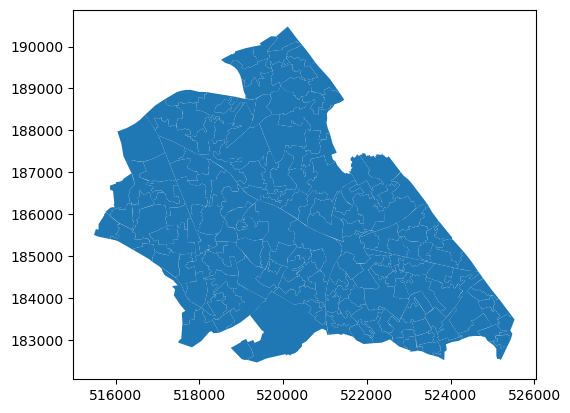

In [33]:
gdf[gdf['LSOA21NM'].str.contains('Brent')].plot()